# ML Experimentation Tool

This notebook demonstrates a simple tool for experimenting with different feature combinations in machine learning models. We'll use the Iris dataset as an example.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import itertools
from sklearn.datasets import load_iris

In [16]:
class MLExperimentationTool:
    def __init__(self, data=None):
        if data is None:
            # Load the Iris dataset as an example
            iris = load_iris()
            self.data = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                                     columns=iris['feature_names'] + ['target'])
        else:
            self.data = data
        
        self.X = self.data.drop('target', axis=1)
        self.y = self.data['target']
        self.feature_sets = []
        self.results = []

    def generate_feature_sets(self, max_features=None):
        all_features = list(self.X.columns)
        print(all_features)
        if max_features is None:
            max_features = len(all_features)
        
        for i in range(1, max_features + 1):
            self.feature_sets.extend(itertools.combinations(all_features, i))

        # print self.feature_sets list with text describing it
        print(f"Generated {len(self.feature_sets)} feature sets with {max_features} features each")

    def run_experiments(self, test_size=0.2, random_state=42):
        for feature_set in self.feature_sets:
            X_subset = self.X[list(feature_set)]
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_subset, self.y, test_size=test_size, random_state=random_state
            )
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model = RandomForestClassifier(random_state=random_state)
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)
            
            self.results.append({
                'features': feature_set,
                'accuracy': accuracy
            })

    def get_best_result(self):
        return max(self.results, key=lambda x: x['accuracy'])

    def print_results(self):
        for result in sorted(self.results, key=lambda x: x['accuracy'], reverse=True):
            print(f"Features: {result['features']}, Accuracy: {result['accuracy']:.4f}")

Now, let's use our ML Experimentation Tool with the Iris dataset:

In [17]:
print("Experimenting with Iris dataset:")
tool = MLExperimentationTool()  # This will automatically load the Iris dataset
tool.generate_feature_sets(2)  # Generate all possible feature combinations
tool.run_experiments()
tool.print_results()
print("\nBest result:", tool.get_best_result())

Experimenting with Iris dataset:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Generated 10 feature sets with 2 features each
Features: ('petal width (cm)',), Accuracy: 1.0000
Features: ('sepal length (cm)', 'petal length (cm)'), Accuracy: 1.0000
Features: ('petal length (cm)', 'petal width (cm)'), Accuracy: 1.0000
Features: ('sepal length (cm)', 'petal width (cm)'), Accuracy: 0.9667
Features: ('petal length (cm)',), Accuracy: 0.9333
Features: ('sepal width (cm)', 'petal length (cm)'), Accuracy: 0.9333
Features: ('sepal width (cm)', 'petal width (cm)'), Accuracy: 0.9333
Features: ('sepal length (cm)',), Accuracy: 0.7667
Features: ('sepal length (cm)', 'sepal width (cm)'), Accuracy: 0.7667
Features: ('sepal width (cm)',), Accuracy: 0.5333

Best result: {'features': ('petal width (cm)',), 'accuracy': 1.0}


The Iris dataset used in this example can be found at:
https://archive.ics.uci.edu/ml/datasets/iris

It's also available through scikit-learn's datasets module, as demonstrated in the code.

## Using Your Own Dataset

If you want to use your own dataset, you can do so by loading it into a pandas DataFrame and passing it to the MLExperimentationTool constructor. Here's an example:

In [ ]:
# Uncomment and modify these lines to use your own dataset
# custom_data = pd.read_csv('your_data.csv')
# tool = MLExperimentationTool(custom_data)
# tool.generate_feature_sets()
# tool.run_experiments()
# tool.print_results()
# print("\nBest result:", tool.get_best_result())

In [8]:
import numpy as np
from scipy.optimize import curve_fit
import plotly.graph_objs as go
from plotly.subplots import make_subplots

class ScalingLawsTool:
    def __init__(self):
        self.compute_budgets = []
        self.model_sizes = []
        self.validation_losses = []
        self.training_tokens = []

    def add_data_point(self, compute, model_size, val_loss, tokens):
        self.compute_budgets.append(compute)
        self.model_sizes.append(model_size)
        self.validation_losses.append(val_loss)
        self.training_tokens.append(tokens)

    def plot_isoflops_curves(self):
        unique_computes = np.unique(self.compute_budgets)
        fig = go.Figure()
        
        for compute in unique_computes:
            mask = np.array(self.compute_budgets) == compute
            tokens = np.array(self.training_tokens)[mask]
            losses = np.array(self.validation_losses)[mask]
            
            # Fit a 2nd degree polynomial
            coeffs = np.polyfit(np.log10(tokens), losses, 2)
            poly = np.poly1d(coeffs)
            
            # Plot the fitted curve
            x = np.logspace(np.log10(min(tokens)), np.log10(max(tokens)), 100)
            fig.add_trace(go.Scatter(x=x, y=poly(np.log10(x)), 
                                     mode='lines', name=f'Compute: {compute:.0e} FLOPs'))
            fig.add_trace(go.Scatter(x=tokens, y=losses, mode='markers', 
                                     name=f'Data {compute:.0e} FLOPs', showlegend=False))

        fig.update_layout(
            xaxis_type="log",
            xaxis_title="Training Tokens",
            yaxis_title="Validation Loss",
            title="IsoFLOPs Curves"
        )
        fig.show()

    def find_optimal_tokens(self):
        unique_computes = np.unique(self.compute_budgets)
        optimal_tokens = []
        
        for compute in unique_computes:
            mask = np.array(self.compute_budgets) == compute
            tokens = np.array(self.training_tokens)[mask]
            losses = np.array(self.validation_losses)[mask]
            
            # Fit a 2nd degree polynomial
            coeffs = np.polyfit(np.log10(tokens), losses, 2)
            
            # Find the minimum analytically
            optimal_log_tokens = -coeffs[1] / (2 * coeffs[0])
            optimal_tokens.append(10**optimal_log_tokens)

        return unique_computes, optimal_tokens

    def fit_scaling_law(self):
        computes, optimal_tokens = self.find_optimal_tokens()

        def power_law(x, A, alpha):
            return A * x**alpha

        params, _ = curve_fit(power_law, computes, optimal_tokens)
        A, alpha = params

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=computes, y=optimal_tokens, mode='markers', name='Computed Optima'))
        x = np.logspace(np.log10(min(computes)), np.log10(max(computes)), 100)
        fig.add_trace(go.Scatter(x=x, y=power_law(x, A, alpha), mode='lines', 
                                 name=f'Fit: N* = {A:.3f} * C^{alpha:.3f}'))
        
        fig.update_layout(
            xaxis_type="log",
            yaxis_type="log",
            xaxis_title="Compute Budget (FLOPs)",
            yaxis_title="Optimal Training Tokens",
            title="Scaling Law: Optimal Tokens vs Compute"
        )
        fig.show()

        return A, alpha

    def predict_optimal_size(self, target_compute):
        A, alpha = self.fit_scaling_law()
        optimal_tokens = A * target_compute**alpha
        
        # Estimate model size (this is a simplification and may need adjustment)
        estimated_size = target_compute / optimal_tokens / 6  # Assuming 6 FLOPs per token per parameter
        
        return optimal_tokens, estimated_size

# Example usage
tool = ScalingLawsTool()

# Add data points (these are hypothetical, you'd use real data)
compute_budgets = [1e19, 1e20, 1e21, 1e22]
for compute in compute_budgets:
    for size in [1e8, 1e9, 1e10]:
        tokens = np.random.uniform(1e9, 1e12)
        loss = np.random.uniform(0.5, 1.5)
        tool.add_data_point(compute, size, loss, tokens)

# Generate plots and find optimal model size
tool.plot_isoflops_curves()
A, alpha = tool.fit_scaling_law()

# Predict for a larger compute budget
target_compute = 3.8e25  # Llama 3's compute budget
optimal_tokens, estimated_size = tool.predict_optimal_size(target_compute)

print(f"For a compute budget of {target_compute:.1e} FLOPs:")
print(f"Optimal number of training tokens: {optimal_tokens:.2e}")
print(f"Estimated optimal model size: {estimated_size:.2e} parameters")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

<Figure size 1200x800 with 0 Axes>

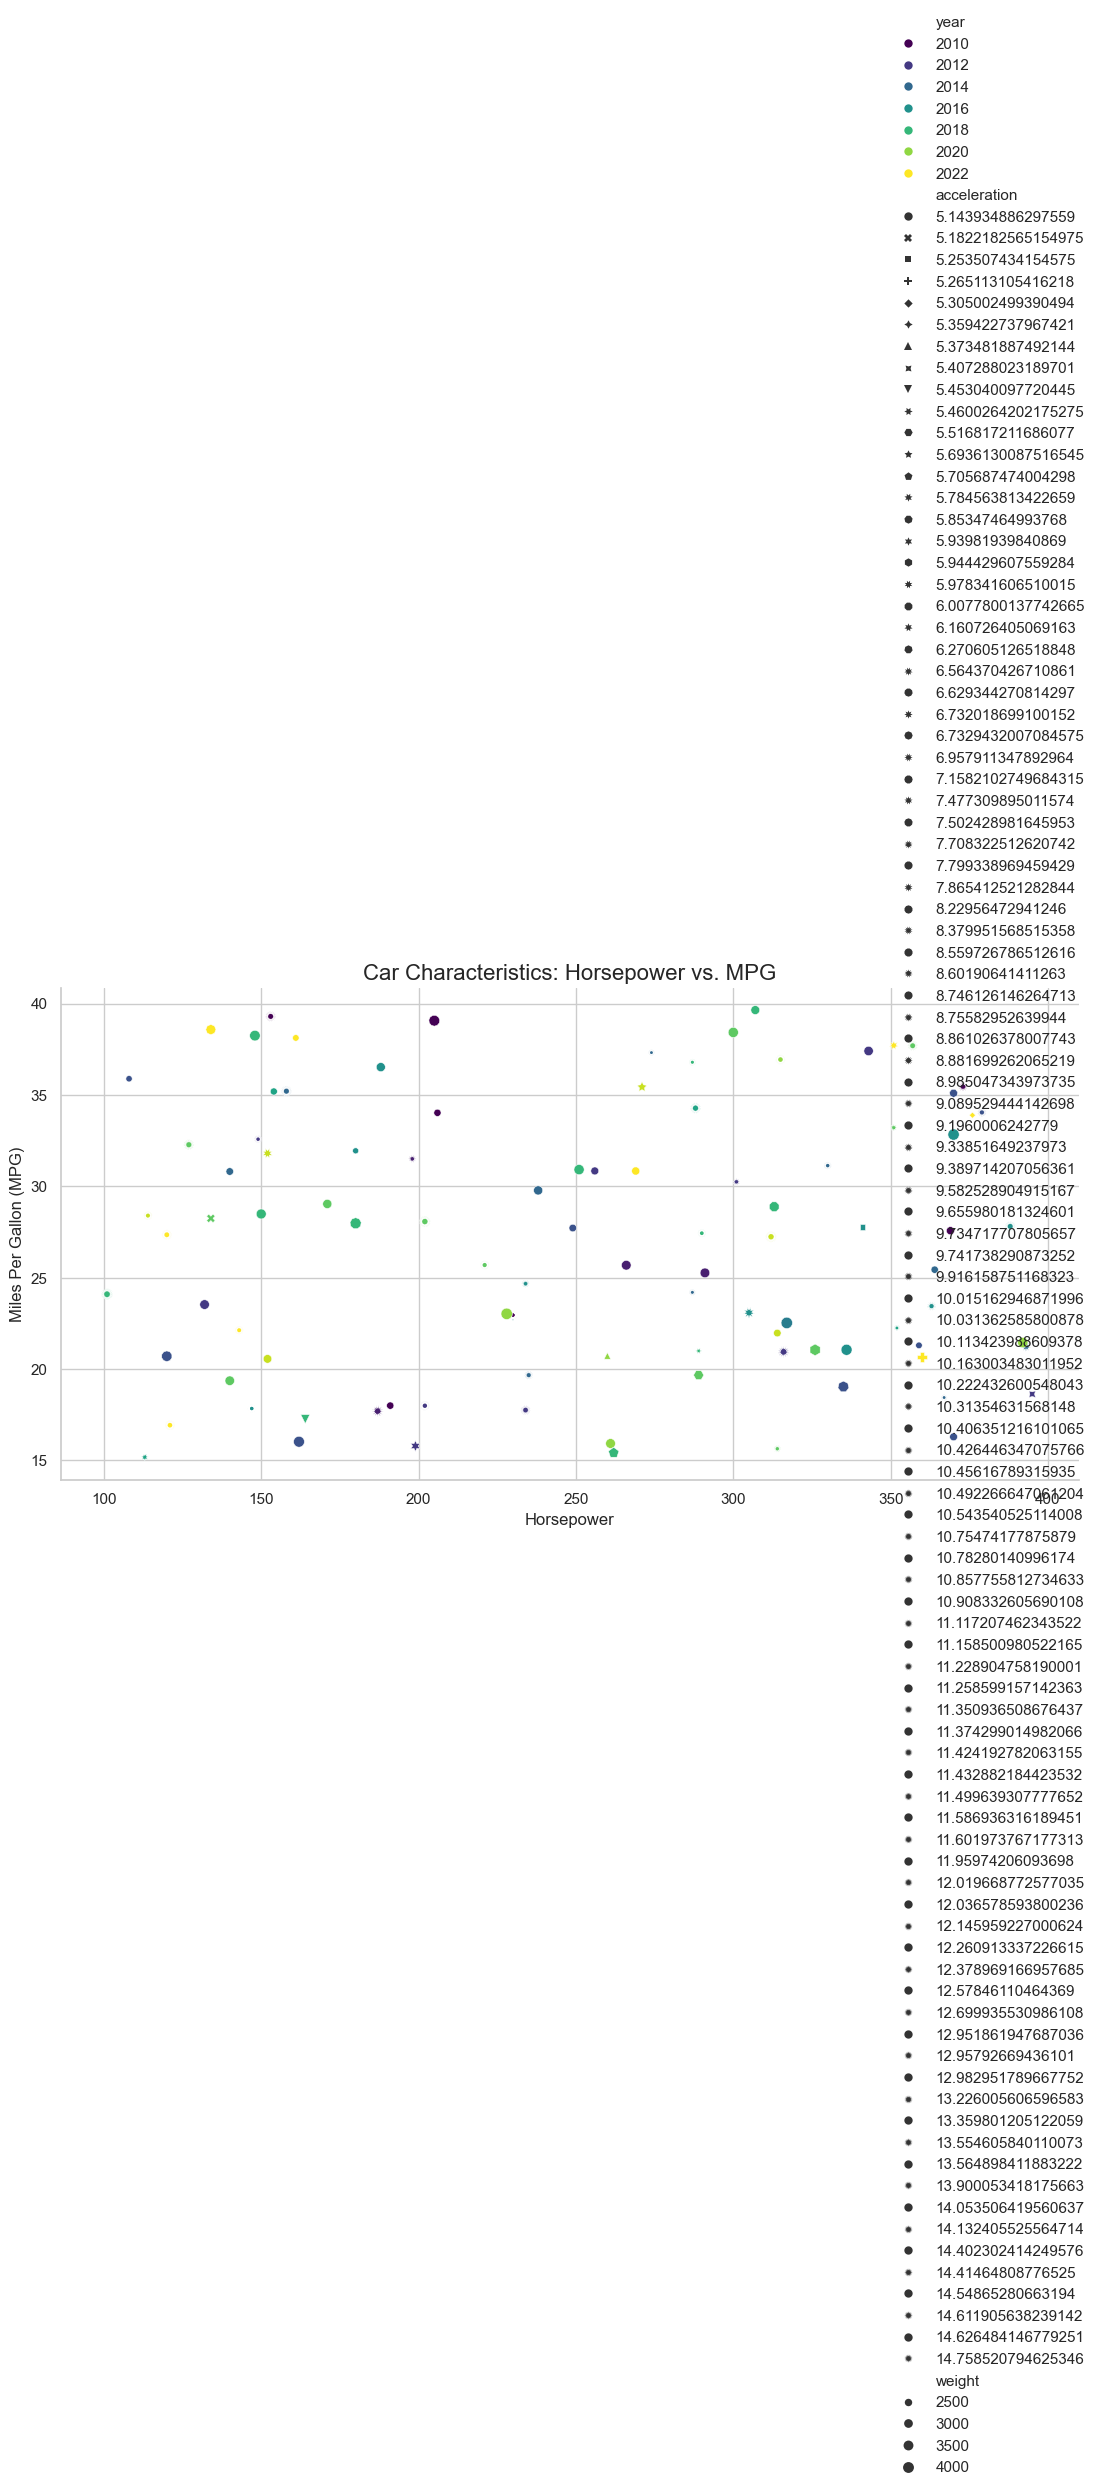

       horsepower         mpg       weight  acceleration         year
count  100.000000  100.000000   100.000000    100.000000   100.000000
mean   252.200000   26.946079  3220.780000      9.624804  2016.180000
std     87.852378    7.190618   698.090854      2.864430     3.685571
min    101.000000   15.173803  2016.000000      5.143935  2010.000000
25%    163.500000   20.977020  2601.000000      6.901669  2013.000000
50%    260.500000   27.388051  3199.500000      9.965661  2016.000000
75%    327.000000   32.924692  3803.250000     11.590696  2019.000000
max    395.000000   39.641261  4485.000000     14.758521  2022.000000


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic car data
n_cars = 100
cars_df = pd.DataFrame({
    'horsepower': np.random.randint(100, 400, n_cars),
    'mpg': np.random.uniform(15, 40, n_cars),
    'weight': np.random.randint(2000, 4500, n_cars),
    'acceleration': np.random.uniform(5, 15, n_cars),
    'year': np.random.randint(2010, 2023, n_cars)
})

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create the relational plot
plt.figure(figsize=(12, 8))
sns.relplot(
    data=cars_df, 
    x='horsepower', 
    y='mpg',
    hue='year',
    size='weight',
    style='acceleration',
    palette='viridis',
    height=6,
    aspect=1.5
)

# Customize the plot
plt.title('Car Characteristics: Horsepower vs. MPG', fontsize=16)
plt.xlabel('Horsepower', fontsize=12)
plt.ylabel('Miles Per Gallon (MPG)', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Save the plot
# plt.savefig('car_relplot.png', dpi=300, bbox_inches='tight')

# Print summary statistics
print(cars_df.describe())